In [25]:
from googleapiclient.discovery import build
import pandas as pd
from IPython.display import JSON
from dateutil import parser
import isodate
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# # NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
# from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to /home/nhat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nhat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
from dotenv import load_dotenv
import os
load_dotenv()

api_key = os.getenv("api_key")

In [36]:
channel_ids = ['UCIUt1auGAZGqo3jmeP-LB1g','UCQxFc2GZvTAfwgikTwPJSkA',]

In [37]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)


In [38]:
def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

In [39]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [40]:
channel_stats

channelName subscribers     views totalVideos                playlistId
0     V√™ T√™ L·ªù          47     17347          66  UUIUt1auGAZGqo3jmeP-LB1g
1  To√†n Nguy·ªÖn      256000  56851349        1823  UUQxFc2GZvTAfwgikTwPJSkA

In [15]:
playlist_id = "UUQxFc2GZvTAfwgikTwPJSkA"

def get_video_ids(youtube, playlist_id):

    video_ids = []

    request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId=playlist_id,
            maxResults=50
        )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part='contentDetails',
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token
        )

        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        
        next_page_token = response.get('nextPageToken')

    return video_ids

In [16]:
video_ids = get_video_ids(youtube, playlist_id)

In [17]:
len(video_ids)

1824

In [40]:
def get_video_details(youtube, video_ids):
    
    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet, contentDetails, statistics",
            id=','.join(video_ids[i:i+50])
        )

        response = request.execute()
        
        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None
            
            all_video_info.append(video_info)
        
    return pd.DataFrame(all_video_info)

In [41]:
video_df = get_video_details(youtube, video_ids)
video_df

video_id channelTitle  \
0     WfyaSfkA96g  To√†n Nguy·ªÖn   
1     xDoIL9Bqfi0  To√†n Nguy·ªÖn   
2     uIqdIQR9bIY  To√†n Nguy·ªÖn   
3     zpm1mZgLQ4Q  To√†n Nguy·ªÖn   
4     t9ZOmUzBNhk  To√†n Nguy·ªÖn   
...           ...          ...   
1794  9f6BxN2boCY  To√†n Nguy·ªÖn   
1795  d5VcLUAjntA  To√†n Nguy·ªÖn   
1796  8-3_1AviAIk  To√†n Nguy·ªÖn   
1797  XVOmSkIaQro  To√†n Nguy·ªÖn   
1798  t6nwY6_I3sg  To√†n Nguy·ªÖn   

                                                  title  \
0     5 ƒêi·ªÅu ƒë√†n b√† th√¥ng minh nh·∫•t ƒë·ªãnh ph·∫£i l√†m tr...   
1                         Ki·ªÉu ng∆∞·ªùi ko n√™n y√™u #shorts   
2                             th√≠ch qu√† n√†o h∆°n #shorts   
3     5 Nguy√™n t·∫Øc ·ª©ng x·ª≠ ti·ªÅn b·∫°c v·ªõi ƒë√†n √¥ng c·ªßa p...   
4        Ng∆∞·ªùi ·∫•y mu·ªën d·ª´ng l·∫°i? H√£y n√≥i c√¢u n√†y #short   
...                                                 ...   
1794  Top 5 ƒëi·ªÅu ƒë√†n √¥ng th·∫•y h·∫•p d·∫´n ·ªü ph·ª• n·ªØ - B√≠ ...   
1795  T·∫°i sao con g√°i hay gi·∫≠n d·ªói v√† t·∫ßm quan tr·ªçng...   
1796  T·ªïng h·ª£p c√°c c√°ch k·∫øt h·ª£p qu·∫ßn ·ªëng r·ªông ƒë·∫ßy ƒë·ªß...   
1797  8 B√≠ Quy·∫øt Th·ªùi Trang Gi√∫p B·∫°n Lu√¥n Sang Tr·ªçng...   
1798  7 m·∫πo  th·ªùi trang cho ng∆∞·ªùi g·∫ßy lu√¥n h·∫•p d·∫´n /...   

                                            description  \
0     5 ƒêi·ªÅu ƒë√†n b√† th√¥ng minh nh·∫•t ƒë·ªãnh ph·∫£i l√†m tr...   
1                                                         
2                                                         
3     5 Nguy√™n t·∫Øc ·ª©ng x·ª≠ ti·ªÅn b·∫°c v·ªõi ƒë√†n √¥ng c·ªßa p...   
4                                                         
...                                                 ...   
1794  B·∫°n ch∆∞a h·∫°nh ph√∫c trong t√¨nh y√™u? b·∫°n t·ª± h·ªèi ...   
1795  N·∫øu ƒë√£ h∆°n m·ªôt l·∫ßn ƒë·∫∑t c√¢u h·ªèi t·∫°i sao con g√°i...   
1796  B·∫°n y√™u th√≠ch qu·∫ßn ·ªëng r·ªông nh∆∞ng kh√¥ng bi·∫øt m...   
1797  L√†m sao ƒë·ªÉ b·∫°n lu√¥n sang tr·ªçng m·ªói ng√†y? Nh·ªØng...   
1798  Nhi·ªÅu ch·ªã em g·∫ßy c√≥ t√¢m s·ª± l√† th·∫≠t kh√≥ ƒë·ªÉ ch·ªçn...   

                                                   tags           publishedAt  \
0     [To√†n Nguy·ªÖn, toan nguyen, t√¨nh y√™u b√≠ quy·∫øt, ...  2023-03-03T13:00:21Z   
1                                                  None  2023-03-02T13:29:15Z   
2                                                  None  2023-03-02T13:11:52Z   
3     [To√†n Nguy·ªÖn, toan nguyen, t√¨nh y√™u b√≠ quy·∫øt, ...  2023-03-02T13:00:42Z   
4                                                  None  2023-03-01T14:21:08Z   
...                                                 ...                   ...   
1794  [Top 5 ƒëi·ªÅu ƒë√†n √¥ng th·∫•y h·∫•p d·∫´n ·ªü ph·ª• n·ªØ, B√≠ ...  2019-05-05T10:58:45Z   
1795  [T·∫°i sao con g√°i hay gi·∫≠n d·ªói v√† t·∫ßm quan tr·ªçn...  2019-05-03T13:43:58Z   
1796  [t·ªïng h·ª£p c√°ch k·∫øt h·ª£p qu·∫ßn ·ªëng r·ªông, tong hop...  2018-06-09T01:09:03Z   
1797  [8 b√≠ quy·∫øt th·ªùi trang gi√∫p b·∫°n lu√¥n sang tr·ªçn...  2018-04-16T15:37:53Z   
1798  [th·ªùi trang cho ng∆∞·ªùi g·∫ßy, c√°c ch·ªçn ƒë·ªì cho ng∆∞...  2016-08-29T08:35:22Z   

     viewCount likeCount favouriteCount commentCount  duration definition  \
0          291        21           None            0  PT10M17S         hd   
1         2319        69           None            0     PT55S         hd   
2          859        51           None            0     PT26S         hd   
3         2540       112           None            0  PT14M46S         hd   
4         6537       147           None            0     PT58S         hd   
...        ...       ...            ...          ...       ...        ...   
1794     42867       729           None           27  PT12M26S         hd   
1795     29449       527           None           41  PT10M40S         hd   
1796     77078       254           None            5  PT21M25S         hd   
1797    143431       738           None           24  PT10M13S         hd

In [16]:
def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)     


In [17]:
comments_df = get_comments_in_videos(youtube, video_ids)

Could not get comments for video wCMJ0uMAAeo
Could not get comments for video _5p0_R5osR8
Could not get comments for video VBS-VG264gU


In [61]:
comments_df

video_id                        comments
0   1XADpb94foI                              []
1   GriL5mOucOI                              []
2   a7eNWhEp0-4  [ƒë·∫ßm ·∫•m qu√° ·∫°, happy new year]
3   xyDoFxlYXl4                              []
4   cJ7XUMFVarc           [k·∫øt v·ªôi th·∫ø anh zai]
..          ...                             ...
58  8uEFzXc5p5g                              []
59  WcsU3UfFXAg                              []
60  lDAKtJvvVOc                              []
61  ORWg20EIWvc                              []
62  FK6Vo1lilPU                              []

[63 rows x 2 columns]

In [60]:
len(comments_df)

63

Data preprocessing

In [64]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [65]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [66]:
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [70]:
#Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x :x.strftime("%A"))

In [71]:
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]') 

In [72]:
video_df[['durationSecs', 'duration']]

durationSecs duration
0          318.0  PT5M18S
1          113.0  PT1M53S
2           21.0    PT21S
3          138.0  PT2M18S
4          235.0  PT3M55S
..           ...      ...
61           5.0     PT5S
62           8.0     PT8S
63           9.0     PT9S
64         244.0   PT4M4S
65         200.0  PT3M20S

[66 rows x 2 columns]

In [73]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [74]:
video_df

video_id channelTitle  \
0   1XADpb94foI     V√™ T√™ L·ªù   
1   GriL5mOucOI     V√™ T√™ L·ªù   
2   a7eNWhEp0-4     V√™ T√™ L·ªù   
3   xyDoFxlYXl4     V√™ T√™ L·ªù   
4   cJ7XUMFVarc     V√™ T√™ L·ªù   
..          ...          ...   
61  8uEFzXc5p5g     V√™ T√™ L·ªù   
62  WcsU3UfFXAg     V√™ T√™ L·ªù   
63  lDAKtJvvVOc     V√™ T√™ L·ªù   
64  ORWg20EIWvc     V√™ T√™ L·ªù   
65  FK6Vo1lilPU     V√™ T√™ L·ªù   

                                                title  \
0                      K·ªÉ chuy·ªán 5 th√°ng trong 5 ph√∫t   
1           N∆∞·ªõc ƒëi n√†y h∆°i sai cho ƒëi l·∫°i ƒë∆∞·ª£c kh√¥ng   
2   My first Tet away from home #tet2023 #daisuqua...   
3   B·∫øt x√°c - ƒê√¢y l√† nh·ªØng g√¨ m√¨nh nh·ªõ h√¥m ƒë√≥ u·ªëng...   
4   CHUY·∫æN ƒêI CU·ªêI C√ôNG C·ª¶A NƒÇM 2022 - CH·ªêT H·∫†AAA!...   
..                                                ...   
61                                    FLYING WITH BEE   
62                                          FOLLOW ME   
63                                    FLYING WITH BEE   
64                                VietNam my homeland   
65                   Behind The Scenes-MV Tet Holiday   

                                          description  \
0   N∆°i l∆∞u gi·ªØ k·ªâ ni·ªám cho tu·ªïi thanh xu√¢n \n‚ñ∫ Su...   
1                                                       
2                                 T·∫øt xa nh√† ƒë·∫ßu ti√™n   
3   U·ªëng m·∫•t x√°c\n‚ñ∫ Subscribe: https://youtu.be/AT...   
4   M·ªôt chuy·∫øn ƒëi 1 m√¨nh t·ª± th∆∞·ªüng cho b·∫£n th√¢n v√¨...   
..                                                ...   
61                                                      
62                                                      
63                                                      
64                                                      
65                                                      

                                                 tags publishedAt  viewCount  \
0   [# Flyingbee, #B√°chkhoa, T·∫•u H√†i, Trip everyyear]   Wednesday      106.0   
1                                                None   Wednesday       14.0   
2                                                None     Tuesday       49.0   
3   [# Flyingbee, #B√°chkhoa, T·∫•u H√†i, Trip everyyear]    Thursday       25.0   
4   [# Flyingbee, #B√°chkhoa, T·∫•u H√†i, # Flyingbee,...    Thursday      161.0   
..                                                ...         ...        ...   
61                                               None    Saturday       22.0   
62                                               None   Wednesday       23.0   
63                                               None     Tuesday       20.0   
64                                               None   Wednesday       90.0   
65                                               None   Wednesday       67.0   

    likeCount  favouriteCount  commentCount duration definition caption  \
0         4.0             NaN           0.0  PT5M18S         hd   false   
1         2.0             NaN           0.0  PT1M53S         hd   false   
2         3.0             NaN           2.0    PT21S         hd   false   
3         2.0             NaN           0.0  PT2M18S         hd   false   
4         3.0             NaN           1.0  PT3M55S         hd   false   
..        ...             ...           ...      ...        ...     ...   
61        0.0             NaN           0.0     PT5S         hd   false   
62        0.0             NaN           0.0     PT8S         hd   false   
63        0.0             NaN           0.0     PT9S         hd   false   
64        1.0             NaN           0.0   PT4M4S         sd   false   
65        1.0             NaN           0.0  PT3M20S         hd   false   

    durationSecs  tagCount  
0          318.0         4  
1          113.0         0  
2           21.0         0  
3          138.0         4  
4          235.0         9  
..           ...       ...  
61           5.0         0  
62           8

# **EDA**

# Best performing videos

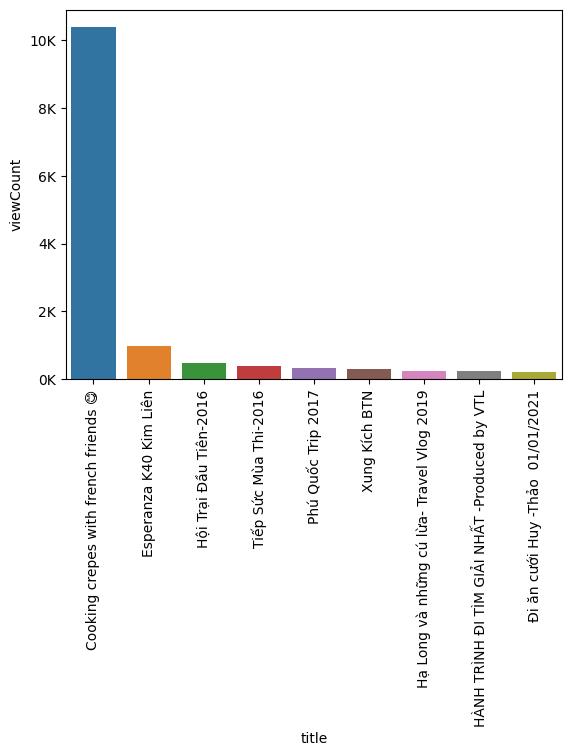

In [83]:
ax = sns.barplot(x='title', y='viewCount', data=video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

# Worst performing videos

/home/nhat/Documents/Project/youtube_api/my_env/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 127468 (\N{REGIONAL INDICATOR SYMBOL LETTER G}) missing from current font.
  func(*args, **kwargs)
/home/nhat/Documents/Project/youtube_api/my_env/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from current font.
  func(*args, **kwargs)
/home/nhat/Documents/Project/youtube_api/my_env/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 127809 (\N{MAPLE LEAF}) missing from current font.
  func(*args, **kwargs)
/home/nhat/Documents/Project/youtube_api/my_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127468 (\N{REGIONAL INDICATOR SYMBOL LETTER G}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/nhat/Documents/Project/youtube_api/my_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarni

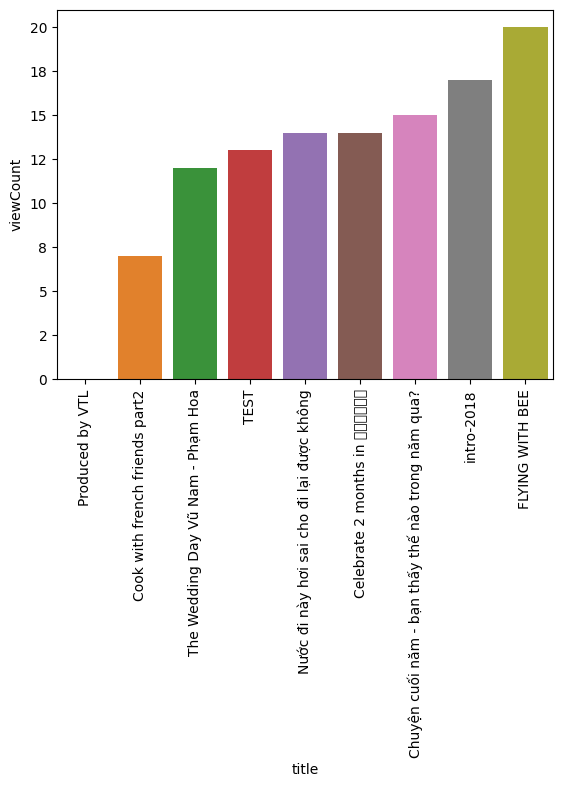

In [99]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x)))





In [23]:
request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
response = request.execute()
print(response['items'])

[{'kind': 'youtube#channel', 'etag': '3vgjCLQjF98gbvEylxYmBkvdcZo', 'id': 'UCIUt1auGAZGqo3jmeP-LB1g', 'snippet': {'title': 'V√™ T√™ L·ªù', 'description': 'K√™nh l∆∞u gi·ªØ k·ªâ ni·ªám c·ªßa cu·ªôc ƒë·ªùi V√™ T√™ L·ªù \nCapturing every moment as if its your last \nFLYING WITH ME', 'customUrl': '@vetelo612', 'publishedAt': '2015-07-29T17:05:51Z', 'thumbnails': {'default': {'url': 'https://yt3.ggpht.com/vmuIMuBTsLbCPEZ3s8W4BQxMS4b8JA6l7dntD-X-Njf-HmmgFgjo9tZM7MCezbeH1S27c4Km=s88-c-k-c0x00ffffff-no-rj', 'width': 88, 'height': 88}, 'medium': {'url': 'https://yt3.ggpht.com/vmuIMuBTsLbCPEZ3s8W4BQxMS4b8JA6l7dntD-X-Njf-HmmgFgjo9tZM7MCezbeH1S27c4Km=s240-c-k-c0x00ffffff-no-rj', 'width': 240, 'height': 240}, 'high': {'url': 'https://yt3.ggpht.com/vmuIMuBTsLbCPEZ3s8W4BQxMS4b8JA6l7dntD-X-Njf-HmmgFgjo9tZM7MCezbeH1S27c4Km=s800-c-k-c0x00ffffff-no-rj', 'width': 800, 'height': 800}}, 'localized': {'title': 'V√™ T√™ L·ªù', 'description': 'K√™nh l∆∞u gi·ªØ k·ªâ ni·ªám c·ªßa cu·ªôc ƒë·ªùi V√™ T√™ L·ªù \nCap

# Get video comments

In [71]:
def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    parent_ids = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id,
                maxResults=30
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:30]]
            replies = [comment['replies']['comments']['snippet']['textOriginal'] for comment in response['items'][0:30]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video, 'replies': replies}
            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)     

comment_df = get_comments_in_videos(youtube, ['9f6BxN2boCY'])

Could not get comments for video 9f6BxN2boCY


In [72]:
comment_df

Empty DataFrame
Columns: []
Index: []

In [70]:
len(comment_df['comments'][0])

24

In [78]:
request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId='9f6BxN2boCY',
                maxResults=30
            )
response = request.execute()
print(response)
# comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:30]]
# replies = [comment['replies']['comments']['snippet']['textOriginal'] for comment in response['items'][0:30]]
# comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}
# all_comments.append(comments_in_video_info) 

{'kind': 'youtube#commentThreadListResponse', 'etag': 'gmsOZf6lkBYZXaQejukEjB0lDiM', 'pageInfo': {'totalResults': 24, 'resultsPerPage': 30}, 'items': [{'kind': 'youtube#commentThread', 'etag': 'tUKOqwdIPMLarOLiR2s3iVJkRW8', 'id': 'Ugwa3T138VEGC8d2kN94AaABAg', 'snippet': {'videoId': '9f6BxN2boCY', 'topLevelComment': {'kind': 'youtube#comment', 'etag': 'BlaUfglRLvffD-hj_7A2yv3kezU', 'id': 'Ugwa3T138VEGC8d2kN94AaABAg', 'snippet': {'videoId': '9f6BxN2boCY', 'textDisplay': 'Y√™u ch·ªã so much‚ù§', 'textOriginal': 'Y√™u ch·ªã so much‚ù§', 'authorDisplayName': 'Kim Nghi', 'authorProfileImageUrl': 'https://yt3.ggpht.com/ytc/AL5GRJVRCZif_UW1TBixLi81qZHj_bAggFjepbvxU3CD=s48-c-k-c0x00ffffff-no-rj', 'authorChannelUrl': 'http://www.youtube.com/channel/UC_DScjeV6gqKNc7bLSEyNvg', 'authorChannelId': {'value': 'UC_DScjeV6gqKNc7bLSEyNvg'}, 'canRate': True, 'viewerRating': 'none', 'likeCount': 0, 'publishedAt': '2021-01-28T09:24:09Z', 'updatedAt': '2021-01-28T09:24:09Z'}}, 'canReply': True, 'totalReplyCo

In [18]:
#TEST OnLY
def get_channel_stats(youtube, channel_ids):
    all_data = []

    request = youtube.channels().list(
    part="snippet, statistics, contentDetails",
    id=','.join(channel_ids)
    )
    response = request.execute()
    JSON(response['items'])
    #loop through items
#     for item in response['items']:
#         data = {'channelName': item['snippet']['title'],
#                 'subcribers': item['statistics']['subscriberCount'],
#                 'views': item['statistics']['viewCount'],
#                 'totalViews': item['statistics']['videoCount'],
#                 'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
#                 }
        
#     all_data.append(data)

#     return pd.DataFrame(all_data)
get_channel_stats(youtube, channel_ids)